# Example application of the extended Kalman filter to the Van der Pol oscillator


This notebook demonstrates the application of the extended Kalman filter to the [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>

1. [Creating synthetic data](#synthetic)

1. [Running the EKF](#ekf)



---

## 1. Creating synthetic data <a name="synthetic"></a>

We consider the following system

* States $\mathbf{x} = (x,y)$

* Observations $\mathbf{z} = z$

with 

$$\dot{x} = y + \epsilon_{\rm p}$$

$$\dot{y} = \mu(1-x^2)y - x$$

$$z = x^2 y + y + \epsilon_{\rm m} $$

where $\epsilon_{\rm p}$ is a mean-zero Gaussian process noise, with covariance $\sigma_{\rm p}^2$, and $\epsilon_{\rm m}$ is a mean-zero Gaussian measurement noise, with covariance $\sigma_{\rm m}^2$


This is the second order Van der Pol oscillator recast as a pair of first order ODEs, with some process noise added. The observation $z$ is arbitrarily chosen to be a product of the states.

In [90]:
import numpy as np 
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

class VanDerPol:
    """ Simulates the signal from a Van der Pol oscillator with process noise. 
    
    The observation is an arbitrary, non-linear combination of the states
    """
    
    def __init__(self,μ,σp,σm, x, y,seed):
    
        self.μ  = μ
        self.σp = σp 
        self.σm = σm
        self.x  = x
        self.y  = y
        self.generator = np.random.default_rng(seed)



        
    def take_a_timestep(self):
        """ Call once for each new measurement at dt time from last call.
            Uses a basic Euler method.
        """
        
        #Derivatives
        dx = self.y + self.generator.normal(0, self.σp) #add some process noise to dx
        dy = self.μ*(1-self.x**2)*self.y - self.x 

        #Euler timestep
        self.x = self.x  + self.dt*dx 
        self.y = self.y  + self.dt*dy
        
        #The observation z = x^2 y + y + Gaussian noise
        observation = self.x**2*self.y +self.y + self.generator.normal(0, self.σm) 

        return self.x,self.y,observation



    def integrate(self,dt,n_steps):
        """ Integrate for n_steps timesteps and return an array that holds the states and observations
        """

        self.dt = dt
        self.n_steps   = n_steps

        self.t            = np.arange(0,self.n_steps*self.dt,self.dt)
        self.output_array = np.zeros((self.n_steps,3)) 

        for i in range(self.n_steps):
            self.output_array[i,:] = VDP.take_a_timestep()



    def plot_phase_space(self):
        """
        A plotting function which plots the evolution in the x-y phase plane
        """


        #Setup the figure
        h,w = 6,6
        rows = 1
        cols = 1
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)
    
        x = self.output_array[:,0]
        y = self.output_array[:,1]
        ax.plot(x,y)
        

        #Clean up axes
        fs=20
        ax.set_xlabel('x', fontsize=fs)
        ax.set_ylabel('y', fontsize=fs)
        ax.xaxis.set_tick_params(labelsize=fs-4)
        ax.yaxis.set_tick_params(labelsize=fs-4)


    def plot_timeseries(self,prediction_data=None):
        """
        A plotting function which plots the states/observations as a function of time
        """


        #Setup the figure
        h,w =8,8
        rows = 3
        cols = 1
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(h,w),sharex=True)


        data_label = 'data'
        for i in range(len(axes)):
            axes[i].plot(self.t,self.output_array[:,i],label=data_label)
 

        if prediction_data is not None:
            states = prediction_data[0]
            measurements = prediction_data[1]

            
            prediction_color = 'C2'
            prediction_label = 'prediction'
            axes[0].plot(self.t,states[:,0],c=prediction_color,label=prediction_label)
            axes[1].plot(self.t,states[:,1],c=prediction_color,label=prediction_label)
            
            axes[2].plot(self.t,measurements[:,0],c=prediction_color,label=prediction_label)

            plt.legend(fontsize=12)

        
    
        #Clean up axes
        fs=20
        axes[2].set_xlabel('t', fontsize=fs)

        axes[0].set_ylabel('x', fontsize=fs)
        axes[1].set_ylabel('y', fontsize=fs)
        axes[2].set_ylabel('z', fontsize=fs)

        plt.subplots_adjust(hspace=0.0)

        for ax in axes:
            ax.xaxis.set_tick_params(labelsize=fs-4)
            ax.yaxis.set_tick_params(labelsize=fs-4)

        # ax.legend(prop={'size':fs})



Lets take a quick look at the data

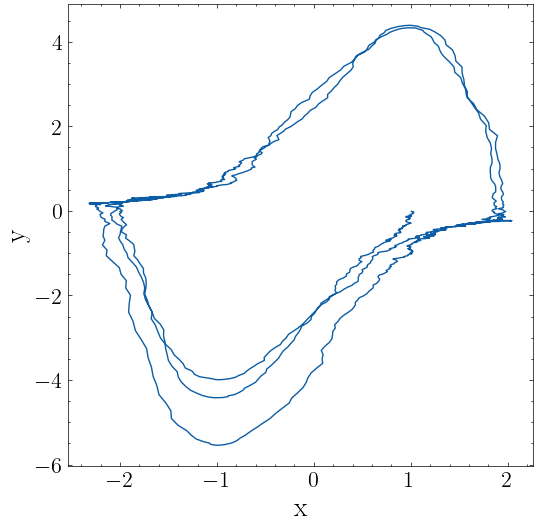

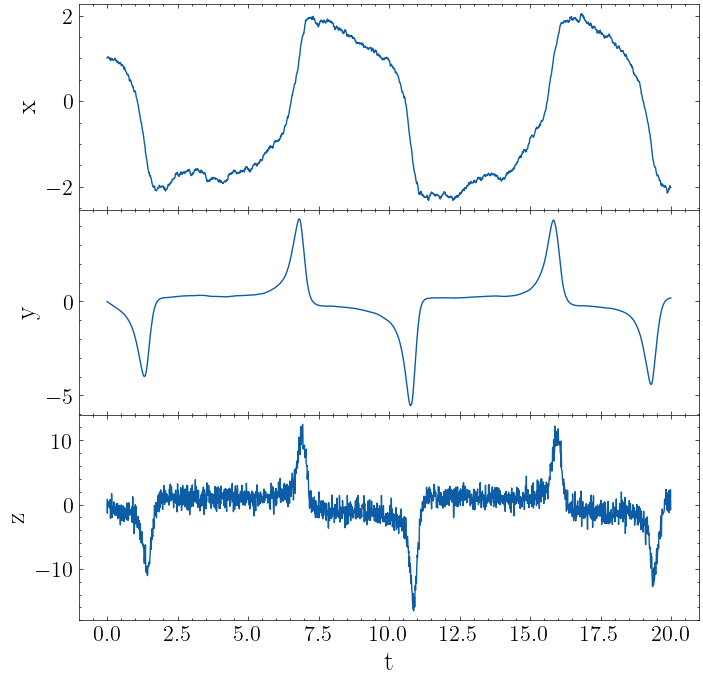

In [62]:
#Parameters of the system
μ    = 3.0
σp   = 2.0
σm   = 1.0
x0   = 1.0
y0   = .0
seed = 1

#Initialise the class
VDP = VanDerPol(μ,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

We can also turn off the process noise, e.g. 

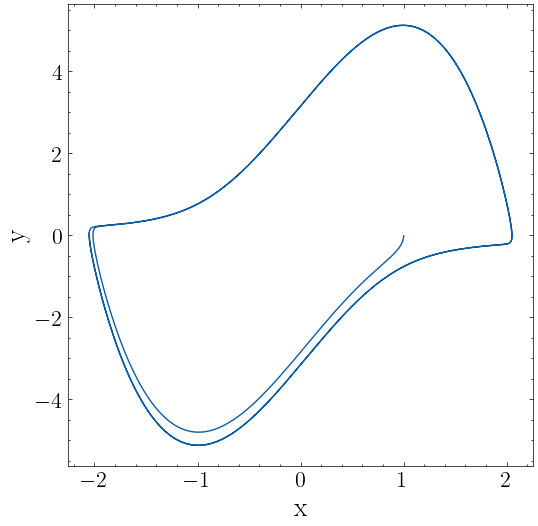

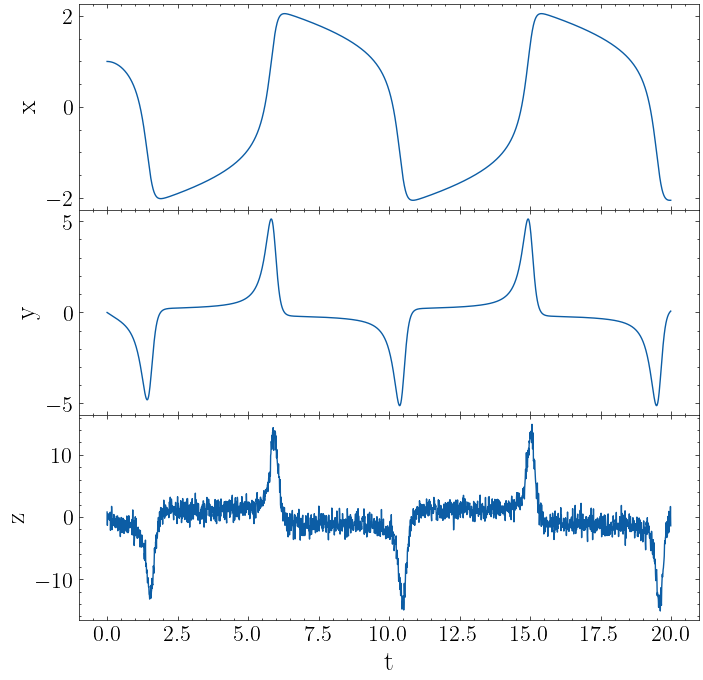

In [63]:
#Initialise the class
VDP = VanDerPol(μ,0.0,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

...and vary the damping constant 

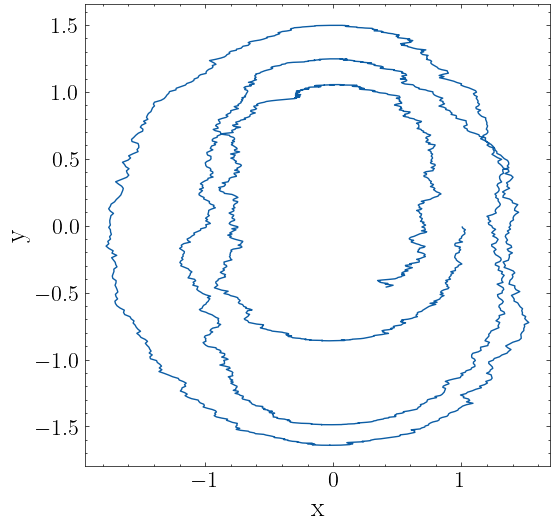

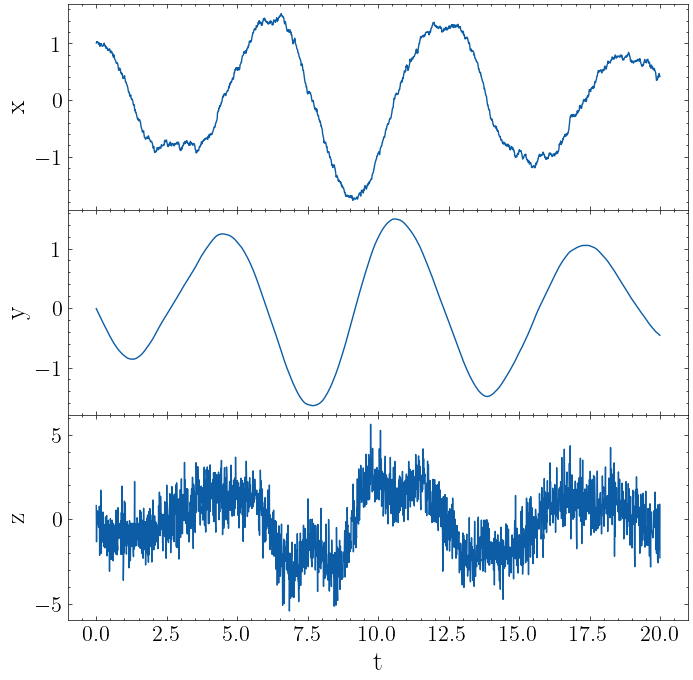

In [64]:
#Initialise the class
VDP = VanDerPol(0.01,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=0.01,n_steps=2000)

#Plot
VDP.plot_phase_space()
VDP.plot_timeseries()

## 2. Mathematics of the Extended Kalman filter


A reccomended resource for extended Kalman filtering is Chapter 7 of ["Fundamentals of Kalman Filtering: A Practical Approach"](https://arc.aiaa.org/doi/book/10.2514/4.102776)


In summary 

* $\mathbf{\dot{x}} = f(\mathbf{x}) + \mathbf{w}$ 

* $\mathbf{z} = h(\mathbf{x}) + \mathbf{v} $

* $\mathbf{w} \sim \mathcal{N}(0,\mathbf{\Sigma}_p)$, $\mathbf{v} \sim \mathcal{N}(0,\mathbf{\Sigma}_m)$

* $\mathbf{F} = \frac{\partial f(\mathbf{x})}{\partial \mathbf{x}}$
* $\mathbf{H} = \frac{\partial h(\mathbf{x})}{\partial \mathbf{x}}$
* $\mathbf{Q} = E(\mathbf{w} \mathbf{w}^{T})$

### 2.1 Mathematics of the Van der Pol EKF


In order to deploy the the extended Kalman filter we need to specify all the Kalman "machinery", i.e. the various model-specific functions and matrices.

The machinery for the VDP model is as follows:


* States $\mathbf{x} = (x,y)$
* State transition function $f(\mathbf{x}) =\begin{bmatrix}
           y \\
           \mu(1-x^2)y - x\\
         \end{bmatrix}$ 

* Observation function $h(\mathbf{x}) = xy$

* State Jacobian $F = \frac{\partial f}{\partial \mathbf{x}} =\begin{pmatrix}
           0 & 1 \\
           -2\mu x y -1 & \mu (1-x^2)\\
         \end{pmatrix}$

* Measurement Jacobian $H = \frac{\partial h}{\partial \mathbf{x}} = \begin{pmatrix}
           y  \\
           x\\
         \end{pmatrix}$

* Fundamental matrix $\mathbf{\Phi}(t) = \mathbf{I} + \mathbf{F} t$

* Discretised Q-matrix $\mathbf{Q} = \int_0^{T_s} \mathbf{\Phi}(t) \mathbf{Q} \mathbf{\Phi}^T(t) dt = \sigma_p^2 T_s\begin{pmatrix} 1 & T_s F_{21}/2 \\ T_s F_{21}/2  & T_s^2 F_{21}^2 / 3  \end{pmatrix}$ 
  * where $F_{21} = -2\mu x y -1$


* R-matrix $\mathbf{R} = \sigma_{\rm m}^2$


The above is implemented in `model.py`(todo implement this as a meta-class, allow used defined models)



## 3. Running the EKF 


We are now in a position to run the EKF on our synthetic data

#### 3.1 Setup 

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import sys
sys.path.append("../src") # add src to path so it can be accessed here 

#### 3.2 Generate data 

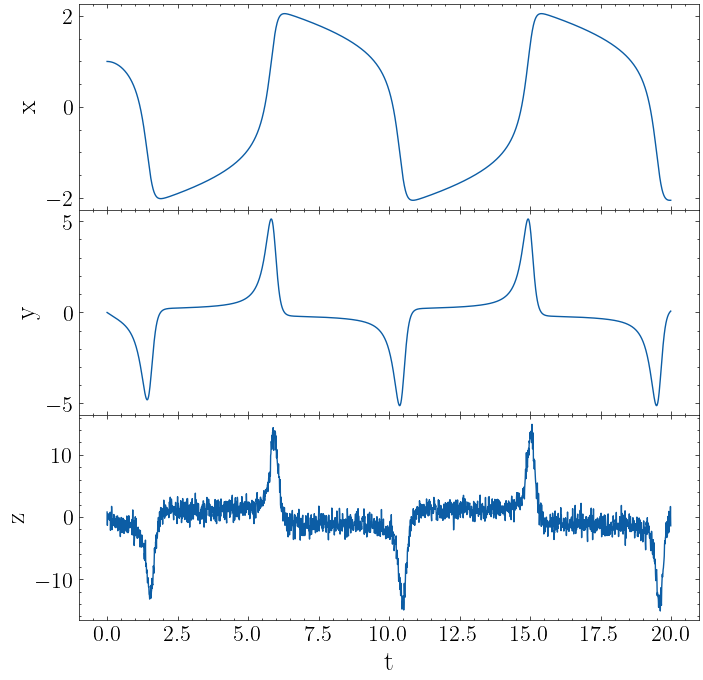

In [147]:
#Parameters of the system
μ    = 3.0
σp   = 0.0 #2.0
σm   = 1.0
x0   = 1.0
y0   = 0.0
seed = 1
dt   = 0.01
n_steps = 2000

#Initialise the class
VDP = VanDerPol(μ,σp,σm, x0, y0,seed)

#Integrate
VDP.integrate(dt=dt,n_steps=n_steps)

#Plot
VDP.plot_timeseries()

#### 3.3 Run the filter 

In [142]:
from model import KalmanVDP
from kalman_filter import ExtendedKalmanFilter
from priors import bilby_priors_dict


{'μ': 3.0, 'σp': 0.0, 'σm': 1.0}
S covar [[5.]] [[1. 0.]
 [0. 1.]]
S covar [[35.494081]] [[0.2        0.        ]
 [0.         8.54909498]]
S covar [[8.47571578]] [[ 0.25957388 -0.16436268]
 [-0.16436268  1.5838827 ]]
S covar [[1.70932584]] [[0.2618728  0.10344668]
 [0.10344668 0.23395965]]
S covar [[3.01557174]] [[ 0.13687298 -0.03149782]
 [-0.03149782  0.60400204]]
S covar [[2.53979832]] [[0.20143569 0.13253052]
 [0.13253052 0.42804864]]
S covar [[3.28606767]] [[ 0.16943063 -0.02900916]
 [-0.02900916  0.64464614]]
S covar [[1.34562213]] [[0.19951253 0.08428204]
 [0.08428204 0.1075583 ]]
S covar [[1.85255576]] [[ 0.08011657 -0.06976118]
 [-0.06976118  0.21348682]]
S covar [[1.05220106]] [[ 0.11523917 -0.01249577]
 [-0.01249577  0.00764458]]
S covar [[1.02328062]] [[0.00730621 0.00070687]
 [0.00070687 0.00538846]]
S covar [[1.005187]] [[ 0.00526874 -0.00154279]
 [-0.00154279  0.00063663]]
S covar [[1.00011671]] [[6.33430043e-04 2.93434498e-05]
 [2.93434498e-05 2.13943365e-05]]
S covar 

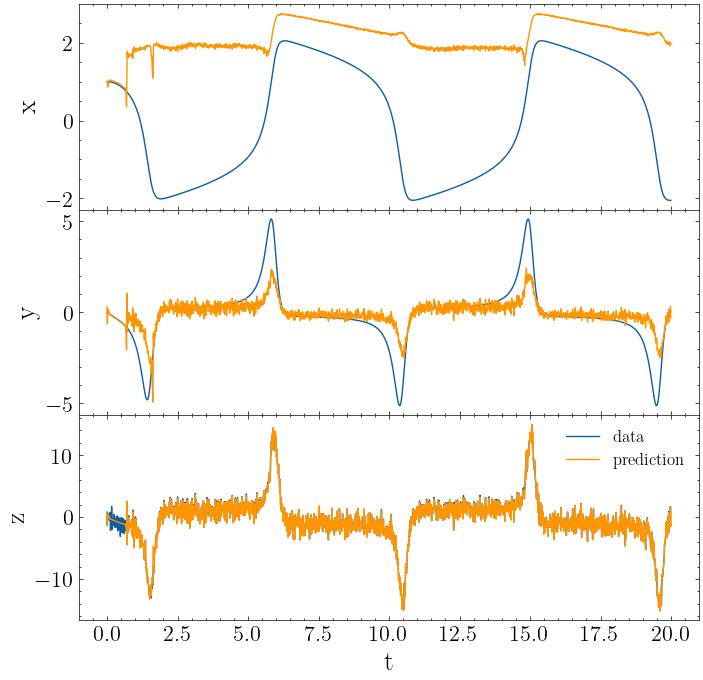

In [148]:
#Define the model
model = KalmanVDP(dt=dt)

#Setup the filter
x_guess = np.array(([x0,y0])) #guess of the initial states. set equal to true values for now. Obv we don't know this in practice/ todo


data = VDP.output_array[:,2] # these are the actual observations 

P0 = 1*np.array(([1.0,0.0],[0.0,1.0]))

KF = ExtendedKalmanFilter(model,data.reshape(len(data),1),x_guess,P0)

#Set the system parameters :: we use bilby keeping an eye on when we will be using this in conjunction with e.g. nested sampling
init_parameters,parameters_dict = bilby_priors_dict(μ,σp,σm)
parameters = parameters_dict.sample()
parameters['σp'] = parameters['σp']
print(parameters)

#Run the filter
KF.run(parameters)

#Plot the results 
VDP.plot_timeseries(prediction_data=[KF.state_predictions,KF.measurement_predictions])

# Appendix / scratch space

In [136]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])

In [137]:
np.dot(a,b)

array([[19, 22],
       [43, 50]])

In [138]:
a@b 

array([[19, 22],
       [43, 50]])

In [2]:
import jax 

ModuleNotFoundError: No module named 'jax'

In [3]:
! pip install jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 MB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.8/736.8 kB 8.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.3 MB/s eta 0:00:00
